#Import bibliotek



In [ ]:
import sys
import numpy as np
from scipy import ndimage as ndi
from skimage import io, filters, color, transform
import cv2 as cv
from scipy.ndimage.morphology import distance_transform_edt
from skimage.morphology import erosion, disk
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

#TODO: Poniżej należy podać ścieżkę do głównego folderu
folder_path = "FolderGlowny"
columns=['Char', 'Image']
sizes = range(4, 71)

In [ ]:
import matplotlib
import skimage
import sklearn
print('numpy: {}'.format(np.__version__))
print('scikit-image: {}'.format(skimage.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('openCV: {}'.format(cv.__version__))
print('sklearn: {}'.format(sklearn.__version__))
print('seaborn: {}'.format(sns.__version__))

import sys
print(sys.version)

numpy: 1.21.6
scikit-image: 0.18.3
pandas: 1.3.5
matplotlib: 3.2.2
openCV: 4.6.0
sklearn: 1.0.2
seaborn: 0.11.2
3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]


In [ ]:
# module level variables ##########################################################################
#Size of the digit
#max numbers of one char 
max_size = 100
#enable chars
enable_chars = ['A', 'a', 'B', 'b', 'C', 'c', 'D', 'd', 'E', 'e', 'F', 'f', 'G', 'g', 'H', 'h', 'I', 'i', 'J', 'j', 'K', 'k', 'L', 'l', 'M', 'm', 'N', 'n', 'O', 'o', 'P', 'p',
                'R', 'r', 'S', 's', 'T', 't', 'U', 'u', 'W', 'w', 'Y', 'y', 'Z', 'z', 'Ä', 'ä', 'Ö', 'ö', 'Q', 'q', 'ẞ', 'ß', 'Ü', 'ü', 'V', 'v', 'X', 'x', '1','2','3', '4', 
                '5', '6', '7', '8', '9', '0', ',', '.', '(', ')', '-', '\'', '\"','+', '=','#', '^', '*', '?', '[', ']', '%', ':',';',
                'ch', 'ck', 'st', 'll', 'ss', 'fi', 'si', 'ff', 'fl']
x = {char: [] for char in enable_chars}
###################################################################################################

# Zapisanie wybranych obrazów zawierających znaki

In [ ]:
def load_to_npz_file(size):
    NPZFile = np.load(folder_path+ '/TrainingFiles/Final/' + str(size) + '.npz', allow_pickle= True)
    x_train, y_train, x_test, y_test = [NPZFile[f] for f in ['x_train', 'y_train', 
                                    'x_test', 'y_test']]
    return x_train, x_test, y_train, y_test

In [ ]:
sizes = {4, 10, 15, 50, 70}
chars = {"ä", "a", "u", "ü"}
for char in chars:
    for size in sizes:
        x_train, x_test, y_train, y_test = load_to_npz_file(size)
        index = np.where(y_train == char)
        #print(index)
        vector = x_train[index[0][20]]
        image = vector.reshape(np.sqrt(vector.shape[0]).astype(np.int64),np.sqrt(vector.shape[0]).astype(np.int64))
        #print(image.shape)
        io.imsave(folder_path + "/Result/Images/" + char + str(size) + "Example.png", image)


# Charakterystyka zbioru danych

In [ ]:
AllData = pd.read_csv(folder_path+ '/TrainingFiles/AllData.csv')
selectedDAta = AllData[AllData['Char'].isin(enable_chars)]

result = np.unique(selectedDAta['Char'], return_counts = True)
df = pd.DataFrame()
df["char"] = result[0]
df["count"] = result[1]

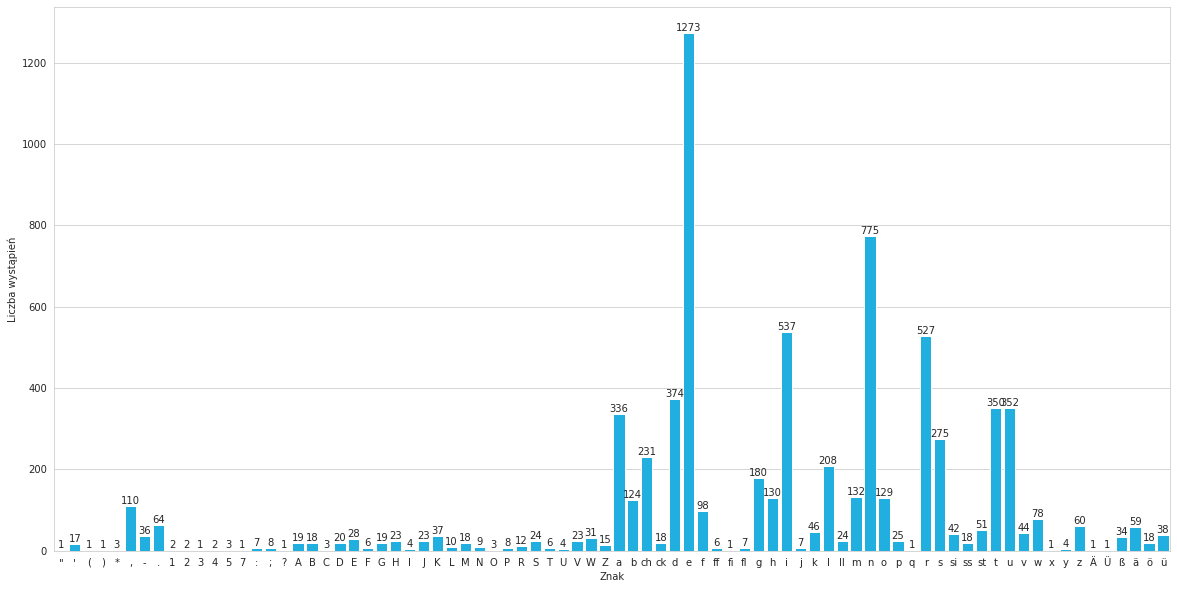

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(figsize=(20, 10))
p = sns.barplot(data=df, x="char", y="count", color= "deepskyblue", errwidth = 0)
p.bar_label(p.containers[0])

p.set_xlabel("Znak")
p.set_ylabel("Liczba wystąpień")
fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/RawDataSet.pdf", bbox_inches='tight') 

In [ ]:
ligaturs = ['ch', 'ck', 'st', 'll', 'ss', 'fi', 'si', 'ff', 'fl']
low_chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
                'r', 's', 't', 'u', 'w', 'y', 'z', 'ä', 'ö', 'q', 'ß', 'ü', 'v', 'x']
high_chars = ['A', 'B',  'C','D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'U', 'W', 'Y', 'Z', 'Ä', 'Ö', 'Q', 'ẞ', 'Ü', 'V', 'X']
special_chars = [ ',', '.', '(', ')', '-', '\'', '\"','+', '=','#', '^', '*', '?', '[', ']', '%', ':',';']
number_chars = [ '1','2','3', '4', '5', '6', '7', '8', '9', '0']


In [ ]:
ligastursCount = df[df['char'].isin(ligaturs)].sum(axis=0,numeric_only=True)
LowCharsCount = df[df['char'].isin(low_chars)].sum(axis=0,numeric_only=True)
HighCharsCount = df[df['char'].isin(high_chars)].sum(axis=0,numeric_only=True)
numbersCount = df[df['char'].isin(number_chars)].sum(axis=0,numeric_only=True)
specialCharsCount = df[df['char'].isin(special_chars)].sum(axis=0,numeric_only=True)
allCharsCount = df.sum(axis=0, numeric_only=True)

In [ ]:
ligatursPercent = (ligastursCount/allCharsCount)*100
LowCharsPercent = (LowCharsCount/allCharsCount)*100
HighCharsPercent = (HighCharsCount/allCharsCount)*100
NumbersPercent = (numbersCount/allCharsCount)*100
SpecialCharsPercent = (specialCharsCount/allCharsCount)*100

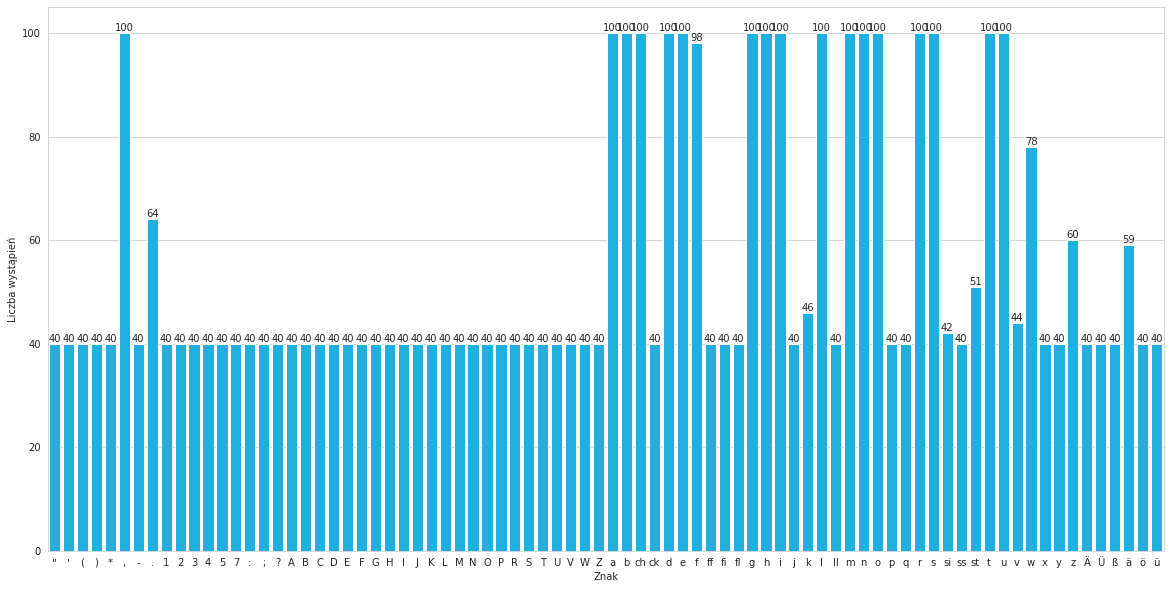

In [ ]:
NPZFile = np.load(folder_path+ '/TrainingFiles/AllDataTrain.npz', allow_pickle= True)
X, Y = [NPZFile[f] for f in ['X', "Y"]]
result = np.unique(Y, return_counts = True)
df = pd.DataFrame()
df["char"] = result[0]
df["count"] = result[1]

sns.set_style("whitegrid")
fig, axs = plt.subplots(figsize=(20, 10))
p = sns.barplot(data=df, x="char", y="count", color= "deepskyblue", errwidth = 0)
p.bar_label(p.containers[0])

p.set_xlabel("Znak")
p.set_ylabel("Liczba wystąpień")
fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/DataSet.pdf", bbox_inches='tight') 

In [ ]:
enable_chars.sort()
NPZFile = np.load(folder_path+ '/TrainingFiles/AllDataTrain.npz', allow_pickle= True)
X, Y = [NPZFile[f] for f in ['X', "Y"]]
result = np.unique(Y, return_counts = True)
exist_chars = result[0]
df = pd.DataFrame()
df["char"] = enable_chars
df['Planowany zbiór'] = 1
df['Uzyskany zbiór'] = 0 
for i in range(0,df['char'].shape[0]):
    if df['char'][i] in exist_chars:
        df['Uzyskany zbiór'][i] = 1



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [ ]:
def plotCharComparison(charsToPrint, i, plotwidth = 20):
    charsToPrint = charsToPrint.set_index('char')
    charsToPrint = charsToPrint.transpose()
    sns.set_theme()
    # Draw a heatmap with the numeric values in each cell
    f, ax = plt.subplots(figsize=(plotwidth,1))
    g =sns.heatmap(charsToPrint, fmt="d", linewidths=0.1, ax=ax, cbar=False,cmap="Greens") 
    g.set_xlabel("Znak")
    #g.set_ylabel("Rozpoznany znak", fontsize = 20)

    fig = g.get_figure()
    fig.savefig(folder_path + "/Result/Images/" + str(i) + "WystepowanieZnakow.png", bbox_inches='tight')
    return g;

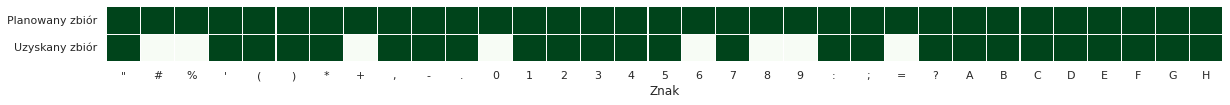

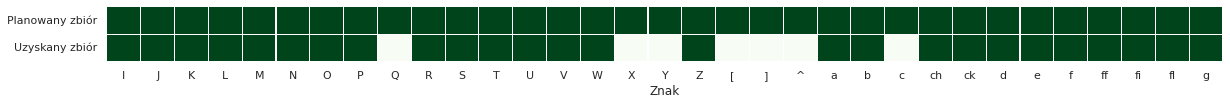

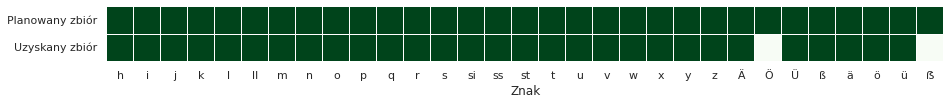

In [ ]:

i = 0
step = int(df.shape[0]/3)+1
while i + step <= df.shape[0]:

    newDf =  df[i:i+step]
    plotCharComparison(newDf, i)
    i = i + step
newDf =  df[i:]
g = plotCharComparison(newDf, i,int(newDf.shape[0]/2))  

# Analiza rozmiaru przestrzeni cech

In [ ]:
score = pd.read_csv(folder_path + "/Result/FeautreSizeTest.csv")
score  = score.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
score['ModelSize'] = score['ModelSize']/(1024*1024)         #thanks to this model size is in [Mb]
score['Size'] = score['Size'] *score['Size'] 

In [ ]:
score = score.replace('RandomForestClassifier()', "Las losowy")
score = score.replace('DecisionTreeClassifier()', "Drzewo decyzyjne")
score = score.replace('KNeighborsClassifier()', "kNN")
score = score.replace('SVC()', "SVM")

In [ ]:
score

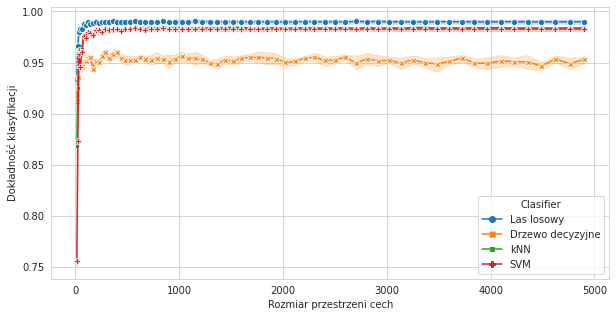

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1, figsize=(10, 5))
p = sns.lineplot(data=score, x="Size", y="Score", hue = 'Clasifier', style="Clasifier",
    markers=True, dashes=False)
p.set_xlabel("Rozmiar przestrzeni cech")
p.set_ylabel("Dokładność klasyfikacji")

fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/FeaturesSizeAccuracy.pdf", bbox_inches='tight') 
plt.show()

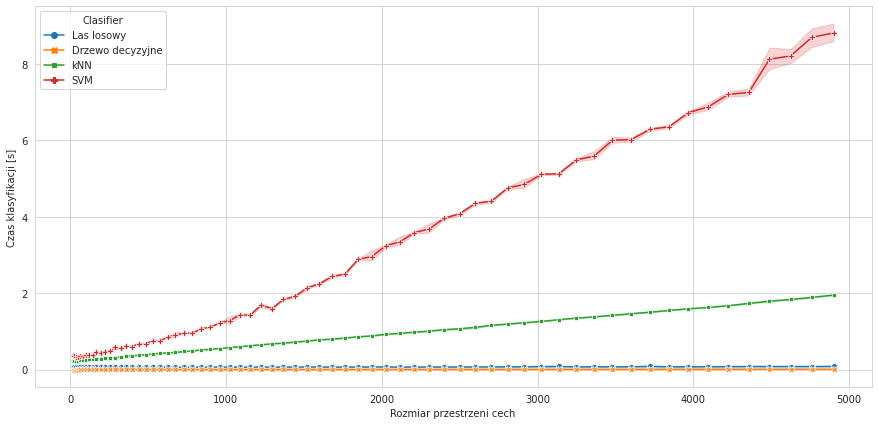

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1, figsize=(15, 7))
p = sns.lineplot(data=score, x="Size", y="TestTime", hue = 'Clasifier', style="Clasifier",
    markers=True, dashes=False)
p.set_xlabel("Rozmiar przestrzeni cech")
p.set_ylabel("Czas klasyfikacji [s]")

fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/FeaturesSizeTestTime.pdf", bbox_inches='tight') 
plt.show()

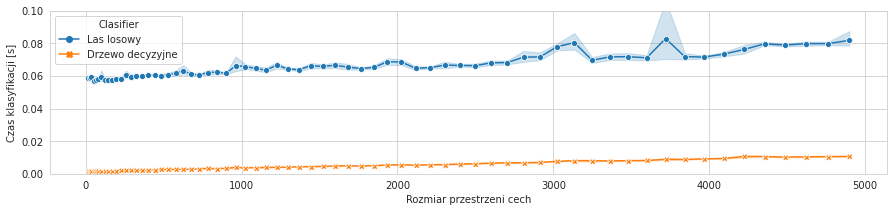

In [ ]:
classifiers = ["Las losowy", "Drzewo decyzyjne"]

sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1, figsize=(15, 3))
p = sns.lineplot(data=score[score['Clasifier'] .isin(classifiers)], x="Size", y="TestTime", hue = 'Clasifier', style="Clasifier",
    markers=True, dashes=False)
p.set_xlabel("Rozmiar przestrzeni cech")
p.set_ylabel("Czas klasyfikacji [s]")

p.set(ylim=(0, 0.1))
fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/FeaturesSizeTestTimeZoom.pdf", bbox_inches='tight') 
plt.show()

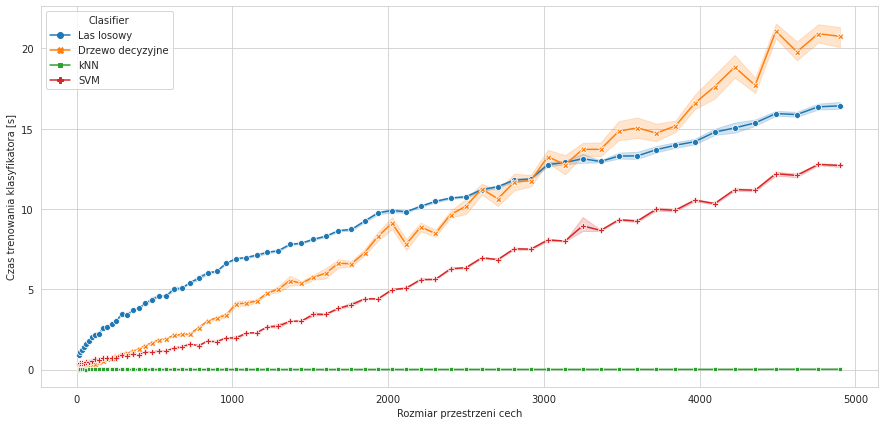

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1, figsize=(15, 7))
p = sns.lineplot(data=score, x="Size", y="TrainingTime", hue = 'Clasifier', style="Clasifier",
    markers=True, dashes=False)
p.set_xlabel("Rozmiar przestrzeni cech")
p.set_ylabel("Czas trenowania klasyfikatora [s]")

fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/FeaturesSizeTrainingTime.pdf", bbox_inches='tight') 
plt.show()

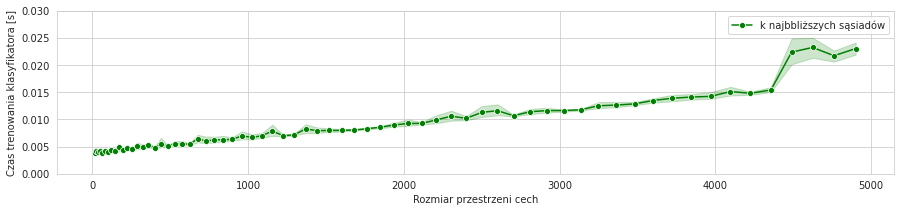

In [ ]:
sns.set_style("whitegrid")
classifier = ["kNN"]
fig, axs = plt.subplots(ncols=1, figsize=(15, 3))
p = sns.lineplot(data=score[score['Clasifier'].isin(classifier)], x="Size", y="TrainingTime", hue = 'Clasifier', style="Clasifier",
    markers=True, dashes=False, palette = ['g'])
p.set_xlabel("Rozmiar przestrzeni cech")
p.set_ylabel("Czas trenowania klasyfikatora [s]")
plt.legend(labels=[ "k najbbliższych sąsiadów"])

p.set(ylim=(0, 0.03))
fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/FeaturesSizeTrainingTimeZoom.pdf", bbox_inches='tight') 
plt.show()

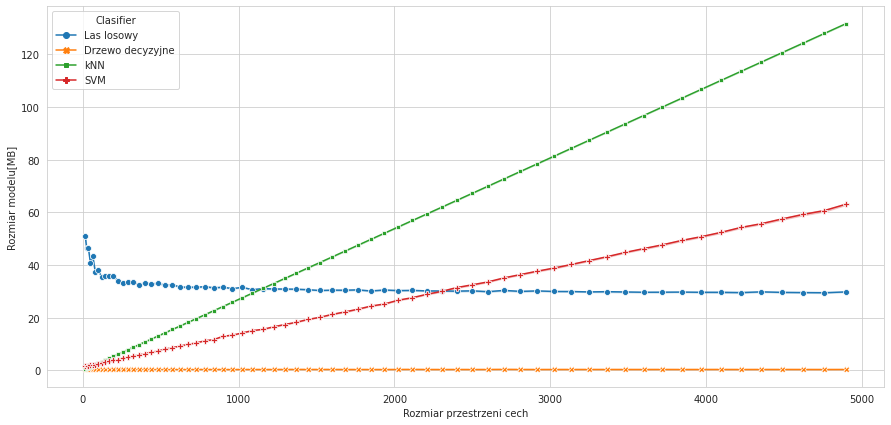

In [ ]:
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1, figsize=(15, 7))
p = sns.lineplot(data=score, x="Size", y="ModelSize", hue = 'Clasifier', style="Clasifier",
    markers=True, dashes=False)
p.set_xlabel("Rozmiar przestrzeni cech")
p.set_ylabel("Rozmiar modelu[MB]")

fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/FeaturesSzeModelSize.pdf", bbox_inches='tight') 
plt.show()

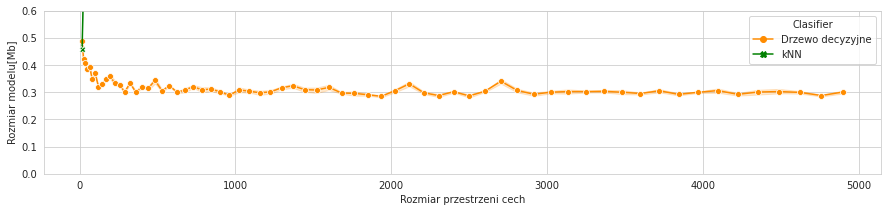

In [ ]:
classifiers = ["Drzewo decyzyjne", "kNN"]
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1, figsize=(15, 3))
p = sns.lineplot(data=score[score['Clasifier'].isin(classifiers)], x="Size", y="ModelSize", hue = 'Clasifier', style="Clasifier",
    markers=True, dashes=False ,palette=['darkorange', 'g'])
p.set_xlabel("Rozmiar przestrzeni cech")
p.set_ylabel("Rozmiar modelu[Mb]")

p.set(ylim=(0, 0.6))
fig = p.get_figure()
fig.savefig(folder_path + "/Result/Images/FeaturesSzeModelSizeZoom.pdf", bbox_inches='tight') 
plt.show()

#Analiza dla pojedynczego rozmiaru przestrzeni cech


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

##Funkcje

In [ ]:
def PlotHeatMap(matrix_of_errors, classifier, size):
    mask = matrix_of_errors <= 0

    sns.set_theme()
    
    f, ax = plt.subplots(figsize=(20, 20))
    g =sns.heatmap(matrix_of_errors, mask = mask, annot=True, fmt="d", linewidths=0.1, ax=ax, cbar=False) 
    g.set_xlabel("Prawdziwy znak", fontsize = 20)
    g.set_ylabel("Rozpoznany znak", fontsize = 20)
    fig = g.get_figure()
    fig.savefig(folder_path + "/Result/Images/" + str(classifier) + str(size) + "matrixOfErrors.pdf", bbox_inches='tight')

In [ ]:
def GetFiltredMatrixOfError(matrix_of_errors):
    chars = matrix_of_errors.columns
    filtred_errors = matrix_of_errors
    for char  in chars:
        if filtred_errors[char].sum(axis=0) == filtred_errors[char][char]:
            if filtred_errors.iloc[:].sum(axis=1)[char] == filtred_errors[char][char]:
                filtred_errors = filtred_errors.drop([char], axis=0)
                filtred_errors = filtred_errors.drop([char], axis=1)
    return filtred_errors

In [ ]:
def PlotFiltredHeatMap(filtred_errors, classifier, size, figsize):
    sns.set_theme()
    mask = filtred_errors <= 0

    f, ax = plt.subplots( figsize=(figsize, figsize))
    g =sns.heatmap(filtred_errors, mask = mask, annot=True, linewidths=0.1, ax=ax, cbar=False, cmap=sns.cm.rocket_r) 
    g.set_xlabel("Prawdziwy znak", fontsize = 20)
    g.set_ylabel("Rozpoznany znak", fontsize = 20)
    fig = g.get_figure()
    fig.savefig(folder_path + "/Result/Images/"+str(classifier) + str(size) + "FiltredHeatMap.pdf", bbox_inches='tight')

In [ ]:
def GetStandartMatrixOfError(matrix):
    chars = matrix.columns
    for char  in chars:
        matrix[char] = matrix[char]/matrix[char].sum();
    return matrix


In [ ]:
def PlotClusterMap(filtred_errors, classifier, size, figsize):
    sns.set_theme()
    
    mask = filtred_errors <= 0
    g =sns.clustermap(filtred_errors, cmap=sns.cm.rocket_r,linewidths=0.1, mask = mask, figsize=(figsize, figsize), annot=True)
    g.ax_heatmap.set_xlabel("Prawdziwy znak", fontsize = 20)
    g.ax_heatmap.set_ylabel("Rozpoznany znak", fontsize = 20)

    fig = g.ax_heatmap.get_figure()
    fig.savefig(folder_path + "/Result/Images/"+str(classifier) + str(size) + "ClusterMap.pdf", bbox_inches='tight')

##Główna analiza

In [ ]:
sizes = {15}
figsize = 10
classifiers = {'KNeighborsClassifier()', 'SVC()', 'RandomForestClassifier(n_jobs=-4)', 'DecisionTreeClassifier()'}

In [ ]:
for size in sizes:
    for classifier in classifiers:
        matrix_of_errors = pd.read_csv(folder_path + "/Result/MatrixOfErrors/" + str(classifier) + str(size) + ".csv")
        matrix_of_errors = matrix_of_errors.set_index("Unnamed: 0")
        PlotHeatMap(matrix_of_errors,classifier, size)
        filtred = GetFiltredMatrixOfError(matrix_of_errors)
        stanardValue = GetStandartMatrixOfError(filtred)
        PlotFiltredHeatMap(filtred, classifier, size, figsize)
        PlotClusterMap(stanardValue, classifier, size, figsize)